In [ ]:
import psycopg2
import pandas as pd

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [ ]:
host="192.168.2.23"
port=5432
user="amt"
dbname="qdap_test"

In [ ]:
def make_connection_to_db(host, port, user, dbname):
    conn = psycopg2.connect(host= host, port=port, user=user, dbname=dbname)
    cursor = conn.cursor()
    return cursor

In [ ]:
def fetch_options_data(cursor, symbol, strike_price, date, month, year, type):
    cursor.execute(
        f'''
            SELECT *
            FROM ohlcv_options_per_minute oopm
            WHERE symbol = '{option}' 
            AND strike = {strike_price} 
            AND extract(year from oopm.expiry) = {year} 
            AND extract(month from oopm.expiry) = {month}
            AND extract(day from oopm.expiry) = {date}
            AND opt_type = '{type}';
        '''
    )
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

def fetch_options_data(cursor, symbol, expiry):
    cursor.execute(
        f'''
            SELECT *
            FROM ohlcv_options_per_minute oopm
            WHERE symbol = '{symbol}' 
            AND expiry_type = 'I'
            AND expiry = (
                SELECT MAX(oopmm.expiry)
                FROM ohlcv_options_per_minute oopmm
                WHERE oopmm.symbol = '{symbol}'
                AND oopmm.expiry_type = 'I'
                AND oopmm.expiry <= '{expiry}'
            )
            ORDER BY date_timestamp ASC;
            
        '''
    )
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [ ]:
def fetch_futures_data(cursor, symbol, x=0):
    query = f'''
        SELECT *
        FROM ohlcv_future_per_minute ofpm
        WHERE ofpm.symbol = '{symbol}'
        AND ofpm.expiry_type = 'I'
        AND ofpm.expiry = (
            SELECT ofpmm.expiry 
            FROM ohlcv_future_per_minute ofpmm
            WHERE ofpmm.symbol = '{symbol}'
            AND ofpmm.expiry_type = 'I'
            GROUP BY ofpmm.expiry
            OFFSET {x}
            LIMIT 1
        )
        ORDER BY date_timestamp ASC;
    '''
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [ ]:
def fetch_equity_data(cursor, symbol, begin, expiry):
    query = f'''
        SELECT *
        FROM ohlcv_cm_per_minute ocpm
        WHERE ocpm.symbol = '{symbol}'
        AND date_timestamp <= '{expiry}'
        AND date_timestamp >= '{begin}'
        ORDER BY date_timestamp ASC;
    '''
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    return df

In [ ]:
def fetch(host, port, user, dbname, symbol, x=15):
    cursor = make_connection_to_db(host, port, user, dbname)
    # hardcoded for near month expiry
    df_futures = fetch_futures_data(cursor, symbol, x) # date is the expiry
    expiry = df_futures['expiry'].iloc[0]
    df_options = fetch_options_data(cursor, symbol, expiry)
    cursor.close()
    conn.close()
    return df_futures, df_options

In [2009]:
symbol = "BANKNIFTY"
x = 20 # index of the array of all the unique expiries of I futures. 

In [2076]:
DF_FUTURES, DF_OPTIONS = fetch(host, port, user, dbname, symbol, x)

In [2078]:
df_futures = DF_FUTURES.copy()
df_options = DF_OPTIONS.copy()

In [2080]:
df_futures = df_futures.drop_duplicates(subset='date_timestamp', keep='first')
df_futures.set_index('date_timestamp', inplace=True)
df_options.set_index('date_timestamp', inplace=True)
df_futures

,symbol,open,low,high,close,volume,expiry,expiry_type,id
date_timestamp,,,,,,,,,
2023-12-01 09:15:00,BANKNIFTY,4479145,4476270,4483685,4482335,48975,2023-12-28 14:30:00,I,13448954
2023-12-01 09:16:00,BANKNIFTY,4482165,4478740,4482625,4482285,29175,2023-12-28 14:30:00,I,60243858
2023-12-01 09:17:00,BANKNIFTY,4482795,4481350,4483715,4483200,27660,2023-12-28 14:30:00,I,13448956
2023-12-01 09:18:00,BANKNIFTY,4483240,4483240,4486500,4486500,23925,2023-12-28 14:30:00,I,60243860
2023-12-01 09:19:00,BANKNIFTY,4486430,4485600,4487500,4486620,15240,2023-12-28 14:30:00,I,13448958
...,...,...,...,...,...,...,...,...,...
2023-12-28 15:25:00,BANKNIFTY,4850775,4850370,4851095,4850655,8535,2023-12-28 14:30:00,I,15301364
2023-12-28 15:26:00,BANKNIFTY,4850655,4850530,4851405,4851100,5400,2023-12-28 14:30:00,I,15301365
2023-12-28 15:27:00,BANKNIFTY,4851100,4850700,4851300,4851015,2130,2023-12-28 14:30:00,I,62096269


In [2082]:
# NOTE THAT OPTIONS AND FUTURES EXPIRY IN THE QDAP DATABASE ARE NOT FOLLOWING THE SAME FORMAT.
expiry_options = pd.Timestamp(df_options['expiry'].iloc[0]).date()
expiry_futures = pd.Timestamp(df_futures['expiry'].iloc[0]).date()
starts_options = pd.Timestamp(df_options.index[0]).date()
starts_futures = pd.Timestamp(df_futures.index[0]).date()

start_intersection = max(starts_options, starts_futures)
end_intersection = min(expiry_options, expiry_futures)
start_intersection = pd.Timestamp.combine(start_intersection, pd.Timestamp('09:15:00').time())
end_intersection = pd.Timestamp.combine(end_intersection, pd.Timestamp('15:29:00').time())

print("starts_options:", starts_options)
print("expiry_options:", expiry_options)
print("starts_futures:", starts_futures)
print("expiry_futures:", expiry_futures)
print("start_intersection:", start_intersection)
print("end_intersection:", end_intersection)

range_futures = (df_futures.index <= end_intersection) & (df_futures.index >= start_intersection)
range_options = (df_options.index <= end_intersection) & (df_options.index >= start_intersection)

df_futures = df_futures[range_futures]
df_options = df_options[range_options]
# df_futures = df_futures[range_futures]
# df_options = df_options[range_options]

starts_options: 2023-12-01
expiry_options: 2023-12-28
starts_futures: 2023-12-01
expiry_futures: 2023-12-28
start_intersection: 2023-12-01 09:15:00
end_intersection: 2023-12-28 15:29:00


In [2084]:
df_futures

,symbol,open,low,high,close,volume,expiry,expiry_type,id
date_timestamp,,,,,,,,,
2023-12-01 09:15:00,BANKNIFTY,4479145,4476270,4483685,4482335,48975,2023-12-28 14:30:00,I,13448954
2023-12-01 09:16:00,BANKNIFTY,4482165,4478740,4482625,4482285,29175,2023-12-28 14:30:00,I,60243858
2023-12-01 09:17:00,BANKNIFTY,4482795,4481350,4483715,4483200,27660,2023-12-28 14:30:00,I,13448956
2023-12-01 09:18:00,BANKNIFTY,4483240,4483240,4486500,4486500,23925,2023-12-28 14:30:00,I,60243860
2023-12-01 09:19:00,BANKNIFTY,4486430,4485600,4487500,4486620,15240,2023-12-28 14:30:00,I,13448958
...,...,...,...,...,...,...,...,...,...
2023-12-28 15:25:00,BANKNIFTY,4850775,4850370,4851095,4850655,8535,2023-12-28 14:30:00,I,15301364
2023-12-28 15:26:00,BANKNIFTY,4850655,4850530,4851405,4851100,5400,2023-12-28 14:30:00,I,15301365
2023-12-28 15:27:00,BANKNIFTY,4851100,4850700,4851300,4851015,2130,2023-12-28 14:30:00,I,62096269


In [2086]:
df_options

,symbol,open,high,low,close,volume,opt_type,strike,expiry_type,id,expiry
date_timestamp,,,,,,,,,,,
2023-12-01 09:15:00,BANKNIFTY,2555,3000,2555,2965,2880,CE,4800000,I,136793371,2023-12-28
2023-12-01 09:15:00,BANKNIFTY,150015,152500,146510,151500,735,CE,4350000,I,136791464,2023-12-28
2023-12-01 09:15:00,BANKNIFTY,51845,52580,49410,51500,12975,CE,4500000,I,136792104,2023-12-28
2023-12-01 09:15:00,BANKNIFTY,9500,10565,9270,9350,4545,CE,4650000,I,136792854,2023-12-28
2023-12-01 09:15:00,BANKNIFTY,70200,72445,68000,68255,4320,PE,4500000,I,136792479,2023-12-28
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 15:29:00,BANKNIFTY,10,10,10,10,165,PE,4090000,I,158757537,2023-12-28
2023-12-28 15:29:00,BANKNIFTY,5,5,5,5,330,PE,4240000,I,158761533,2023-12-28
2023-12-28 15:29:00,BANKNIFTY,5,5,5,5,795,PE,3900000,I,158612789,2023-12-28


In [2104]:
df_calls = df_options[(df_options['opt_type'] == 'CE')]
df_puts  = df_options[(df_options['opt_type'] == 'PE')]

In [2105]:
df_calls_ram = df_calls.pivot(columns='strike', values='close').ffill()
df_puts_ram = df_puts.pivot(columns='strike', values='close').ffill()
df = [df_puts_ram, df_calls_ram]

In [2108]:
print(df_calls_ram.shape)
print(df_futures.shape)

(7125, 119)
(7125, 9)


In [2110]:
df_calls_ram

strike,3600000,3700000,3750000,3800000,3850000,3900000,3950000,3980000,3990000,4000000,...,5070000,5080000,5100000,5150000,5200000,5250000,5300000,5350000,5400000,5450000
date_timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-01 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,930.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 15:25:00,1251825.0,1184195.0,1114320.0,1056185.0,1006000.0,952400.0,900000.0,848955.0,785820.0,852000.0,...,5.0,5.0,5.0,5.0,5.0,5.0,10.0,5.0,5.0,5.0
2023-12-28 15:26:00,1251825.0,1184195.0,1114320.0,1056185.0,1006000.0,952400.0,900000.0,848955.0,785820.0,852000.0,...,5.0,5.0,5.0,5.0,10.0,5.0,10.0,15.0,5.0,5.0
2023-12-28 15:27:00,1251825.0,1184195.0,1114320.0,1056185.0,1006000.0,953000.0,900000.0,848955.0,785820.0,853500.0,...,5.0,5.0,5.0,5.0,5.0,10.0,10.0,10.0,5.0,5.0


In [2112]:
df_puts_ram

strike,3300000,3600000,3650000,3700000,3750000,3800000,3850000,3900000,3950000,3980000,...,5060000,5070000,5080000,5100000,5150000,5200000,5250000,5300000,5350000,5400000
date_timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-01 09:15:00,NaN,NaN,NaN,360.0,NaN,950.0,NaN,NaN,1820.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:16:00,NaN,NaN,NaN,590.0,605.0,945.0,NaN,NaN,1840.0,NaN,...,NaN,NaN,NaN,613000.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:17:00,NaN,NaN,NaN,590.0,605.0,945.0,NaN,NaN,1790.0,1925.0,...,NaN,NaN,NaN,610000.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:18:00,NaN,NaN,NaN,590.0,605.0,945.0,NaN,NaN,1775.0,1930.0,...,NaN,NaN,NaN,610000.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 09:19:00,305.0,NaN,NaN,590.0,605.0,970.0,NaN,NaN,1760.0,1920.0,...,NaN,NaN,NaN,610000.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 15:25:00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,208885.0,218500.0,227875.0,250000.0,298900.0,350235.0,408430.0,447945.0,493515.0,540000.0
2023-12-28 15:26:00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,208885.0,218500.0,227875.0,250000.0,298900.0,350235.0,408430.0,447945.0,493515.0,540000.0
2023-12-28 15:27:00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,208885.0,218500.0,227875.0,250000.0,298900.0,350235.0,408430.0,447945.0,493515.0,540000.0


In [2114]:
def ema(window_short, window_long, df):
    df.loc[:,'short'] = df['close'].ewm(window_short).mean()
    df.loc[:,'long'] = df['close'].ewm(window_long).mean() 
    polarity = df['short'] - df['long']
    polarity = polarity > 0
    signals = []
    position_polarity_positive = polarity.iloc[0]
    for i in range(0, df.shape[0]):
        if(polarity.iloc[i] != position_polarity_positive):
            position_polarity_positive = polarity.iloc[i]
            signals.append((int(position_polarity_positive), df.index[i], df.index[i+1]))
            # bullish -> (1, signal_time, valid_trade_time), bearish -> (0, signal_time, valid_trade_time)
    return signals

In [2116]:
window_short = 9
window_long = 26
signals = ema(window_short, window_long, df_futures)
print(len(signals))
# bullish -> (1, signal_time, valid_trade_time), bearish -> (0, signal_time, valid_trade_time)
print(signals)

135
[(1, Timestamp('2023-12-01 09:17:00'), Timestamp('2023-12-01 09:18:00')), (0, Timestamp('2023-12-01 12:11:00'), Timestamp('2023-12-01 12:12:00')), (1, Timestamp('2023-12-01 13:25:00'), Timestamp('2023-12-01 13:26:00')), (0, Timestamp('2023-12-01 14:11:00'), Timestamp('2023-12-01 14:12:00')), (1, Timestamp('2023-12-04 09:15:00'), Timestamp('2023-12-04 09:16:00')), (0, Timestamp('2023-12-04 11:06:00'), Timestamp('2023-12-04 11:07:00')), (1, Timestamp('2023-12-04 11:15:00'), Timestamp('2023-12-04 11:16:00')), (0, Timestamp('2023-12-05 11:14:00'), Timestamp('2023-12-05 11:15:00')), (1, Timestamp('2023-12-05 12:28:00'), Timestamp('2023-12-05 12:29:00')), (0, Timestamp('2023-12-05 12:31:00'), Timestamp('2023-12-05 12:32:00')), (1, Timestamp('2023-12-05 12:34:00'), Timestamp('2023-12-05 12:35:00')), (0, Timestamp('2023-12-05 12:36:00'), Timestamp('2023-12-05 12:37:00')), (1, Timestamp('2023-12-05 12:49:00'), Timestamp('2023-12-05 12:50:00')), (0, Timestamp('2023-12-05 14:04:00'), Timestam

In [2118]:
def make_trades(signals, expiry):
    trades = []
    # (number, 1/0, 1/0, t, s)
    # (price, call/put, long/short, timestamp, strike) 
    first_signal_type = signals[0][0]
    first_valid_tradable_timestamp = signals[0][2]
    futures_price = df_futures['close'].loc[first_valid_tradable_timestamp]
    # Finding the ITM-1 or ATM option 
    strike = futures_price
    strike //= 50000
    strike += 1-first_signal_type 
    strike *= 50000
    price = df[first_signal_type][strike].loc[first_valid_tradable_timestamp]
    trades.append((price, first_signal_type, 1, first_valid_tradable_timestamp, strike))
    for i, signal in enumerate(signals[1:]):
        try:
            last_trade = trades[len(trades) - 1]
            last_trade_opt_type = last_trade[1]
            last_trade_position = last_trade[2]
            last_strike = last_trade[4]
            signal_nature = signal[0]
            signal_time_stamp = signal[1]
            valid_tradable_time_stamp = signal[2]
            square_off_price = df[last_trade_opt_type][last_strike].loc[valid_tradable_time_stamp]
            current_strike = df_futures['close'].loc[valid_tradable_time_stamp]
            current_strike //= 50000
            current_strike += 1-signal_nature
            current_strike *= 50000
            buying_price = df[signal_nature][current_strike].loc[valid_tradable_time_stamp]
            trades.append((square_off_price, last_trade_opt_type, 1-last_trade_position, valid_tradable_time_stamp, last_strike))
            trades.append((buying_price, signal_nature, 1, valid_tradable_time_stamp, current_strike))
        except:
            print(last_trade_opt_type, last_strike, valid_tradable_time_stamp)
            print(valid_tradable_time_stamp, df[last_trade_opt_type][last_strike])
    last_trade = trades[len(trades) - 1]
    last_trade_opt_type = last_trade[1]
    last_trade_strike = last_trade[4]
    expiry = pd.to_datetime(expiry, format = '%d-%m-%Y')
    last_valid_tradable_time_stamp = pd.Timestamp(f"{expiry} 15:29:00")
    last_square_off_price = df[last_trade_opt_type][last_trade_strike].loc[last_valid_tradable_time_stamp]
    trades.append((last_square_off_price, last_trade_opt_type, 0, last_valid_tradable_time_stamp, last_trade_strike))
    return trades

In [2122]:
trades = make_trades(signals, expiry)
df_trades = pd.DataFrame(trades, columns=['Price', 'Call/Put', 'Position', 'date_timestamp', 'strike_price'])
df_trades = df_trades.set_index('date_timestamp')
print(len(trades))
df_trades

270


,Price,Call/Put,Position,strike_price
date_timestamp,,,,
2023-12-01 09:18:00,82150.0,1,1,4450000
2023-12-01 12:12:00,100680.0,1,0,4450000
2023-12-01 12:12:00,78510.0,0,1,4550000
2023-12-01 13:26:00,78400.0,0,0,4550000
2023-12-01 13:26:00,67275.0,1,1,4500000
...,...,...,...,...
2023-12-28 14:15:00,6665.0,1,0,4850000
2023-12-28 14:15:00,48335.0,0,1,4900000
2023-12-28 15:29:00,48960.0,0,0,4900000


In [2124]:
def PNL(trades):
    net_profit = 0
    profit = 0
    profits = []
    for i, trade in enumerate(trades):
        price = trade[0]
        position = trade[2]
        cash_flow_nature = 1
        if position: # long -> pos = 1, short -> pos = 0
            cash_flow_nature = -1
        if i and (not i%2):
            profits.append(profit)
            profit = 0
        net_profit += cash_flow_nature * price
        profit += cash_flow_nature * price
    return net_profit, profits

In [2126]:
net_profit, profits = PNL(trades)
print(len(profits), net_profit, profits)

134 115940.0 [18530.0, -110.0, -1275.0, -37950.0, 8065.0, -2670.0, 102815.0, 2900.0, -305.0, -90.0, -1175.0, -4525.0, -1670.0, -1835.0, -1365.0, -2790.0, -8400.0, 515.0, -485.0, -1340.0, -2835.0, 160.0, -1300.0, -210.0, 575.0, -1380.0, -2650.0, 3070.0, 13435.0, -4385.0, -2705.0, -2060.0, -1680.0, -10110.0, -2535.0, 1630.0, -5800.0, -4405.0, 23585.0, -1795.0, -415.0, -305.0, -575.0, -2535.0, -1360.0, -2625.0, 550.0, 1825.0, 1330.0, 1905.0, -1010.0, 2780.0, -3880.0, -1540.0, -815.0, -1400.0, -2265.0, -135.0, -3210.0, 4460.0, -1530.0, -555.0, -85.0, -135.0, -685.0, -395.0, -1275.0, -1385.0, 5180.0, -3540.0, 42430.0, -1695.0, -2290.0, -1570.0, -1190.0, -2050.0, 80.0, -1495.0, -3475.0, 840.0, -4685.0, -1360.0, -4970.0, -1660.0, 6680.0, -5550.0, -6050.0, -3555.0, -1745.0, -880.0, -1745.0, 1575.0, -1805.0, -2950.0, -3705.0, 3745.0, 13295.0, -2825.0, 1410.0, -6945.0, -4775.0, -2120.0, -1845.0, 615.0, -2135.0, 62665.0, 16000.0, -6540.0, 14695.0, -6010.0, 9585.0, 16495.0, -14550.0, -6350.0, 8875

In [1674]:
def draw_downs(profits):
    dd = 0
    max_dd = 0
    increments = [(profits[i] - profits[i-1]) for i in range(1, len(profits))]
    dds = []
    dd_falls = 0
    falls_peak_height = 0
    peak = 0
    max_dds_peak_height = 0
    max_dds_peak = 0
    max_dds_peak_temp = 0
    max_dds_peak_height_temp = 0
    max_dds_trough_temp = 0
    max_dds_trough_height_temp = 0
    max_dds_trough_depth = 0
    max_dds_peak_till_now = 0
    max_dds_peak_height_till_now = 0
    max_dds_trough_till_now = 0
    max_dds_trough_depth_till_now = 0
    max_dd_till_now = 0
    max_dds_trough = 0
    began = False
    for i, inc in enumerate(increments): 
        # ending of individual drawdowns
        if(inc > 0 and dd_falls != 0):
            dds.append((dd_falls, (peak, falls_peak_height), (i, profits[i])))
            dd_falls = 0
            began = False
        # marking the beginning of the downfall
        if(inc <= 0):
            if began == False:
                peak = i
                falls_peak_height = profits[i]
            began = True
            peak = min(peak, i)
            dd_falls += inc
        # tracking maximum drawdown
        dd += inc
        if(dd > 0):
            dd  = 0
            max_dds_peak_temp = i+1
            max_dds_peak_height_temp = profits[i+1]
        if(max_dd > dd):
            max_dd = dd
            max_dds_trough_temp = i+1
            max_dds_trough_depth_temp = profits[i+1]
        if(max_dd_till_now > max_dd):
            max_dds_peak_till_now = max_dds_peak_temp
            max_dds_peak_height_till_now = max_dds_peak_height_temp
            max_dds_trough_till_now = max_dds_trough_temp
            max_dds_trough_depth_till_now = max_dds_trough_depth_temp
            max_dd_till_now = max_dd 

    max_dd = [max_dd, (max_dds_peak_till_now, max_dds_peak_height_till_now), (max_dds_trough_till_now, max_dds_trough_depth_till_now)]
    return max_dd, dds

In [1678]:
max_dd, dds = draw_downs(profits)
print(max_dd, dds)

[-117365.0, (6, 102815.0), (112, -14550.0)] [(-56480.0, (0, 18530.0), (3, -37950.0)), (-10735.0, (4, 8065.0), (5, -2670.0)), (-103120.0, (6, 102815.0), (8, -305.0)), (-4435.0, (9, -90.0), (11, -4525.0)), (-165.0, (12, -1670.0), (13, -1835.0)), (-7035.0, (14, -1365.0), (16, -8400.0)), (-3350.0, (17, 515.0), (20, -2835.0)), (-1460.0, (21, 160.0), (22, -1300.0)), (-3225.0, (24, 575.0), (26, -2650.0)), (-17820.0, (28, 13435.0), (29, -4385.0)), (-8430.0, (32, -1680.0), (33, -10110.0)), (-7430.0, (35, 1630.0), (36, -5800.0)), (-25380.0, (38, 23585.0), (39, -1795.0)), (-2230.0, (41, -305.0), (43, -2535.0)), (-1265.0, (44, -1360.0), (45, -2625.0)), (-495.0, (47, 1825.0), (48, 1330.0)), (-2915.0, (49, 1905.0), (50, -1010.0)), (-6660.0, (51, 2780.0), (52, -3880.0)), (-1450.0, (54, -815.0), (56, -2265.0)), (-3075.0, (57, -135.0), (58, -3210.0)), (-5990.0, (59, 4460.0), (60, -1530.0)), (-600.0, (62, -85.0), (64, -685.0)), (-990.0, (65, -395.0), (67, -1385.0)), (-8720.0, (68, 5180.0), (69, -3540.0)

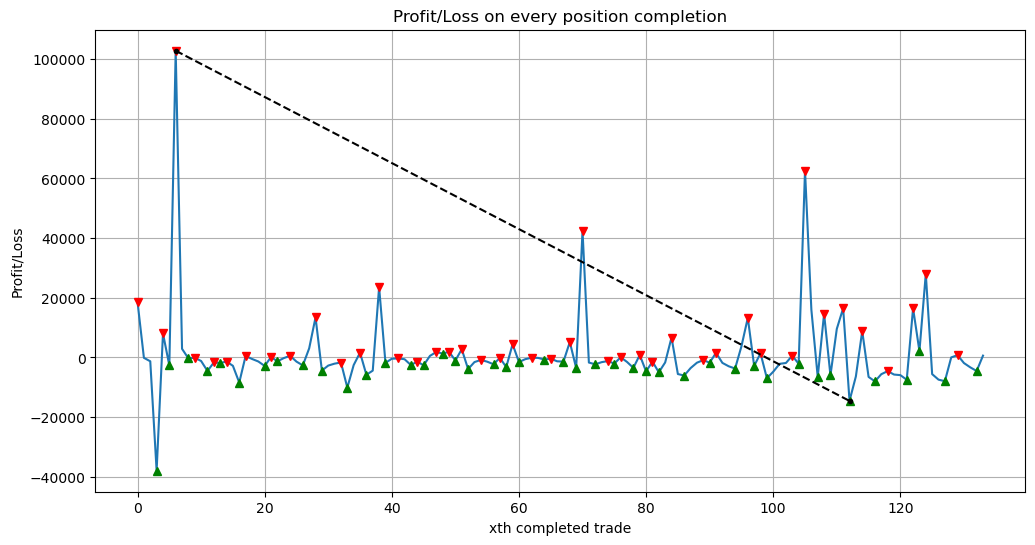

In [1708]:
plt.figure(figsize=(12,6))
plt.plot(profits)
for dd in dds:
    plt.plot(dd[1][0], dd[1][1], marker='v', color='r')
    plt.plot(dd[2][0], dd[2][1], marker='^', color='g')
plt.plot([max_dd[1][0], max_dd[2][0]], [max_dd[1][1], max_dd[2][1]], marker = '.', linestyle='--', color='black')
plt.grid(True)
plt.title("Profit/Loss on every position completion")
plt.xlabel("xth completed trade")
plt.ylabel("Profit/Loss")
plt.show()

In [1746]:
def plot_futures_and_ema(df, start_date, end_date):
    symbol = df['symbol'].iloc[0]
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    df = df.copy()
    df = df.loc[start:end]
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['close']/100, color='black')
    plt.plot(df.index, df['short']/100, color='green')
    plt.plot(df.index, df['long']/100, color='red')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title(f'{symbol} Future Close Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price (in Rs)')
    plt.tight_layout() 
    plt.show()

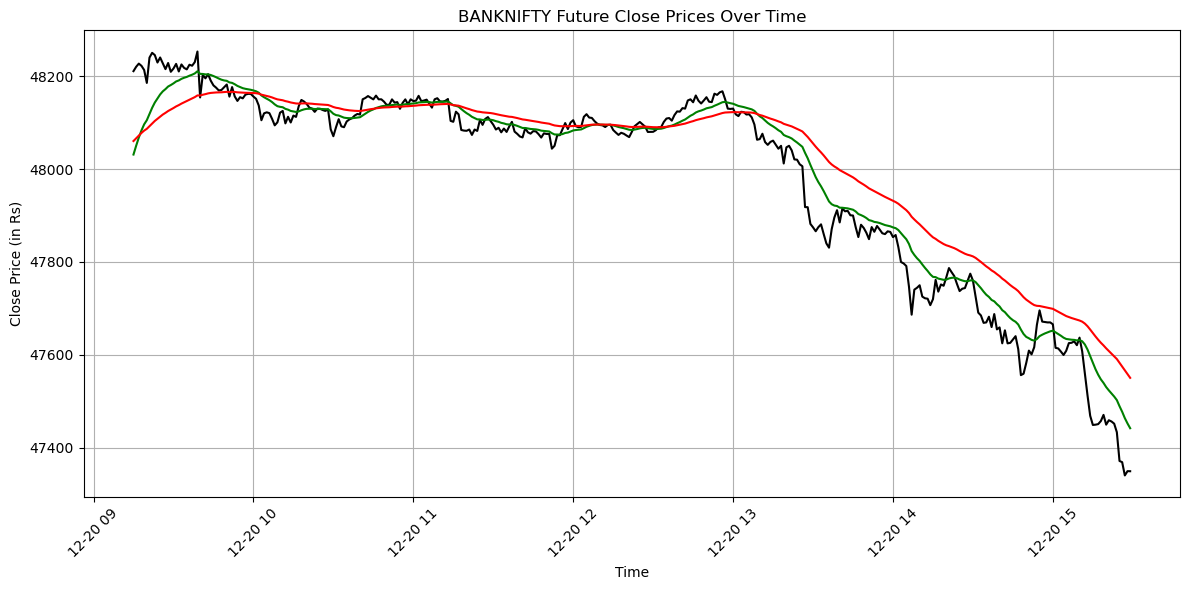

In [1748]:
plot_futures_and_ema(df_futures, '2023-12-20', '2023-12-21')

In [1944]:
def plot_options_and_trades(df_options, df_options_in_ram, opt_type, start_date, end_date, df_trades):
    symbol = df_options['symbol'].iloc[0]
    
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    df_lala_options = df_options_in_ram[opt_type].copy()
    df_lala_options = df_lala_options.loc[start:end]

    df_lala_trades = df_trades[df_trades['Call/Put'] == opt_type]
    df_lala_trades = df_lala_trades.copy().loc[start:end]

    print(df_lala_trades)
    
    strikes_traded = df_lala_trades['strike_price'].unique()
    num_strikes = len(strikes_traded)
    cols = num_strikes// 3 + num_strikes % 3
    rows = (num_strikes// cols) + (num_strikes % cols > 0)

    figure, axes = plt.subplots(rows, cols, figsize=(15, 5*rows), squeeze = False)
    axes = axes.flatten()
    
    for i, strike in enumerate(strikes_traded):
        # plt.figure(figsize=(4, 2))
        ax = axes[i]
        ax.plot(df_lala_options.index, df_lala_options[strike]/100)
        trade_lines = df_lala_trades['strike_price'] == strike
        trade_lines = df_lala_trades[trade_lines]
        # positions = df_call_trades['Position'] == 1
        # traded_long = trade_lines & positions
        # traded_short = trade_lines & ~positions
        # print(traded_long)
        # print(traded_short)
        start_loop = int(trade_lines['Position'].iloc[0] == 0)
        for j in range(start_loop, len(trade_lines)-1, 2):
            ax.plot([trade_lines.index[j], trade_lines.index[j+1]], [trade_lines['Price'].iloc[j]/100, trade_lines['Price'].iloc[j+1]/100], color = 'green', marker="o")
        # ax.plot(df_call_trades.index[traded_long], df_call_trades['Price'][traded_long]/100, color = 'green', marker='o')
        # ax.plot(df_call_trades.index[traded_short], df_call_trades['Price'][traded_short]/100, color = 'red', marker='x')
        name = "Put"
        if opt_type:
            name = "Call"
        ax.set_title(f"{name} Options price and trades with strike = {strike}")
        ax.set_xlabel("time stamps")
        ax.set_ylabel("close prices in Rs")
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
         # Format x-axis with date-time
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
   

    plt.tight_layout() 
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                       Price  Call/Put  Position  strike_price
date_timestamp                                                
2023-12-05 11:15:00  90600.0         0         1       4750000
2023-12-05 12:29:00  93500.0         0         0       4750000
2023-12-05 12:32:00  93510.0         0         1       4750000
2023-12-05 12:35:00  93420.0         0         0       4750000
2023-12-05 12:37:00  65640.0         0         1       4700000
2023-12-05 12:50:00  61115.0         0         0       4700000
2023-12-05 14:05:00  86915.0         0         1       4750000
2023-12-05 14:36:00  85080.0         0         0       4750000
2023-12-05 15:02:00  85320.0         0         1       4750000
2023-12-05 15:05:00  82530.0         0         0       4750000
2023-12-06 09:32:00  93175.0         0         1       4750000
2023-12-06 10:53:00  93690.0         0         0       4750000
2023-12-06 11:54:00  63140.0         0         1       4700000
2023-12-06 12:00:00  61800.0         0         0       

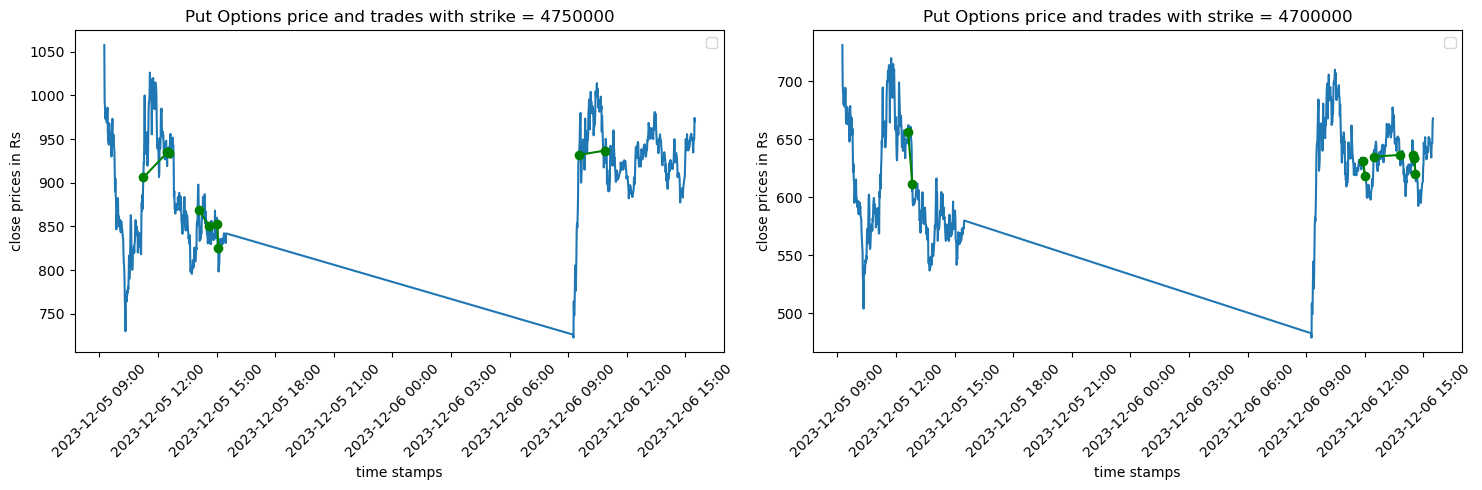

In [1946]:
plot_options_and_trades(df_options, df, 0, '2023-12-05', '2023-12-07', df_trades)

In [2276]:
class metrics:
    def __init__(self, trades, profits, risk_free_rate=5.3/12):
        returns = []
        for i in range(1, len(trades), 2):
            value = (trades["Price"].iloc[i] - trades["Price"].iloc[i-1]) / trades["Price"].iloc[i-1]
            returns.append(value*100)
        self.returns = pd.DataFrame(returns, columns=["return"])
        self.risk_free_rate = risk_free_rate
        self.trades = trades
        self.profits = profits
    
    def number_of_trades(self):
        return self.trades.count().sum()
    
    def sharpe(self):
        self.returns["excess_return"] = self.returns["return"] - self.risk_free_rate
        avg_excess_return = self.returns["excess_return"].mean()
        std_excess_return = self.returns["excess_return"].std()
        sharpe_ratio = avg_excess_return/std_excess_return
        self.sharpe_ratio = sharpe_ratio
        return sharpe_ratio

    def net_profit(self):
        profits = pd.DataFrame(self.profits, columns=['profit'])
        return profits['profit'].sum()

    def net_expenditure(self):
        trades = self.trades
        longs = trades['Position'] == 1
        funded_trades = trades[longs]
        return funded_trades['Price'].sum()

    def net_return(self):
        return 100*self.net_profit()/self.net_expenditure()

In [2278]:
metrics = metrics(df_trades, profits)

In [2280]:
metrics.number_of_trades()

1080

In [2282]:
metrics.sharpe()

0.02040762373389126

In [2260]:
metrics.net_profit()

115940.0

In [2262]:
metrics.net_expenditure()

8166450.0

In [2264]:
metrics.net_return()

1.4197111351933827

In [2266]:
# next task: make auto dynamic fetching of strike ranges progression difference